순환 신경망으로 IMDB 리뷰 분류하기

In [3]:
 from tensorflow.keras.datasets import imdb
 (train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

In [ ]:
# 훈련 데이터 개수
print(train_input.shape, test_input.shape)

# 첫 번째 훈련 데이터 토큰 수
print(len(train_input[0]))

# 첫 번째 훈련 데이터
print(train_input[0])

# 앞선 20개의 훈련 데이터 정답지 (0은 부정, 1은 긍정)
print(train_target[0:20])

(25000,) (25000,)
218
[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [4]:
# 훈련 세트, 검증 세트 분할
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

239.00925 178.0


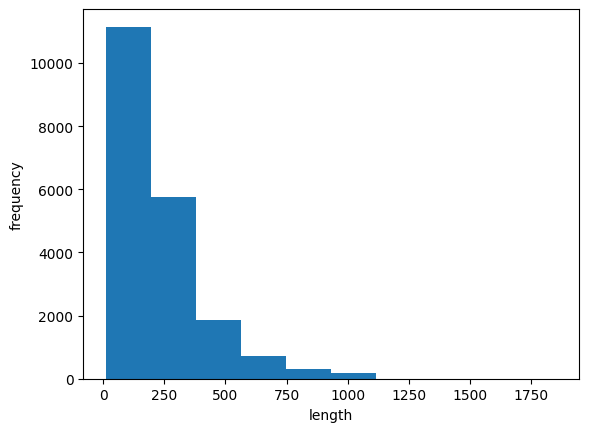

In [ ]:
# 문장에 포함된 단어 개수 평균과 중간값
import numpy as np
lengths = np.array([len(x) for x in train_input])
print(np.mean(lengths), np.median(lengths))

import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [5]:
# 단어 개수 100개로 통합
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
print(train_seq.shape)
print(train_seq[0])
val_seq = pad_sequences(val_input, maxlen=100)

(20000, 100)
[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [ ]:
# 순환 신경망 생성
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
# 원-핫 인코딩
train_oh = keras.utils.to_categorical(train_seq)
val_oh = keras.utils.to_categorical(val_seq)
print(train_oh.shape)

(20000, 100, 500)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 순환 신경망 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64, validation_data=(val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 0.6986 - accuracy: 0.5010

In [7]:
# 단어 임베딩
from tensorflow import keras
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [8]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 200       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 임베딩 모델 학습
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=50, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
313/313 [==============================] - 46s 128ms/step - loss: 0.6923 - accuracy: 0.5199 - val_loss: 0.6894 - val_accuracy: 0.5590
Epoch 2/50
313/313 [==============================] - 37s 119ms/step - loss: 0.6838 - accuracy: 0.6000 - val_loss: 0.6782 - val_accuracy: 0.6238
Epoch 3/50
313/313 [==============================] - 37s 119ms/step - loss: 0.6680 - accuracy: 0.6564 - val_loss: 0.6606 - val_accuracy: 0.6664
Epoch 4/50
313/313 [==============================] - 37s 118ms/step - loss: 0.6477 - accuracy: 0.6955 - val_loss: 0.6414 - val_accuracy: 0.6966
Epoch 5/50
313/313 [==============================] - 36s 116ms/step - loss: 0.6268 - accuracy: 0.7229 - val_loss: 0.6206 - val_accuracy: 0.7272
Epoch 6/50
313/313 [==============================] - 35s 113ms/step - loss: 0.6064 - accuracy: 0.7394 - val_loss: 0.6029 - val_accuracy: 0.7330
Epoch 7/50
313/313 [==============================] - 35s 112ms/step - loss: 0.5869 - accuracy: 0.7524 - val_loss: 0.5853 - val_ac

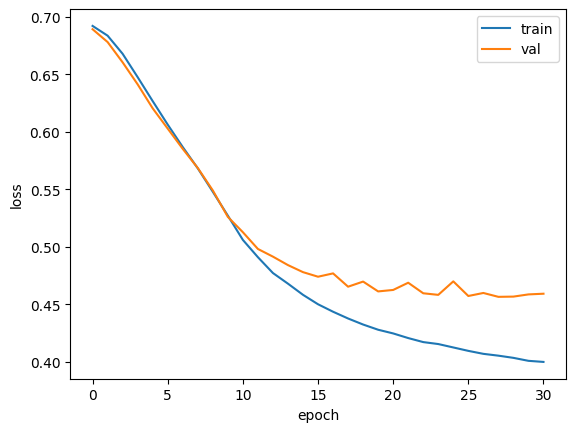

In [13]:
# 손실 그래프
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()